<a href="https://colab.research.google.com/github/SergioLamosLozano/Fundamentos-RN/blob/main/Clasificacion_Corregido.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importamos TensorFlow, una biblioteca para construir y entrenar modelos de machine learning
import tensorflow as tf

# Importamos Matplotlib para poder graficar imágenes y resultados
import matplotlib.pyplot as plt

# Importamos Numpy para realizar operaciones matemáticas y manejar arreglos/matrices
import numpy as np

# Importamos TensorFlow Datasets, que nos permite cargar datasets ya preparados para usar en TensorFlow
import tensorflow_datasets as tfds


In [2]:
# Paso 1: Cargar el conjunto de datos de flores

# Cargamos el dataset 'tf_flowers' desde TensorFlow Datasets
# split=['train[:60%]', 'train[40%:]'] divide el dataset: 60% para entrenamiento y 40% para validación
# as_supervised=True hace que los datos se carguen como tuplas (imagen, etiqueta)
# with_info=True también devuelve información extra sobre el dataset (como número de clases, descripción, etc.)
(ds_train, ds_val), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:60%]', 'train[40%:]'],
    as_supervised=True,
    with_info=True
)

# Verificar el número de clases

# Obtenemos el número de clases del dataset (de la metadata)
num_classes = ds_info.features['label'].num_classes

# Imprimimos cuántas clases tiene el dataset (deberían ser 5 tipos de flores diferentes)
print(f'Número de clases: {num_classes}')  # Debe ser 5


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.NRQG4Z_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
Número de clases: 5


In [3]:
# Importamos el módulo 'drive' de Google Colab para poder trabajar con archivos de Google Drive
from google.colab import drive

# Montamos Google Drive en la ruta '/content/drive'
# Esto nos permite acceder a nuestros archivos de Drive como si fueran archivos locales
drive.mount('/content/drive')


Mounted at /content/drive


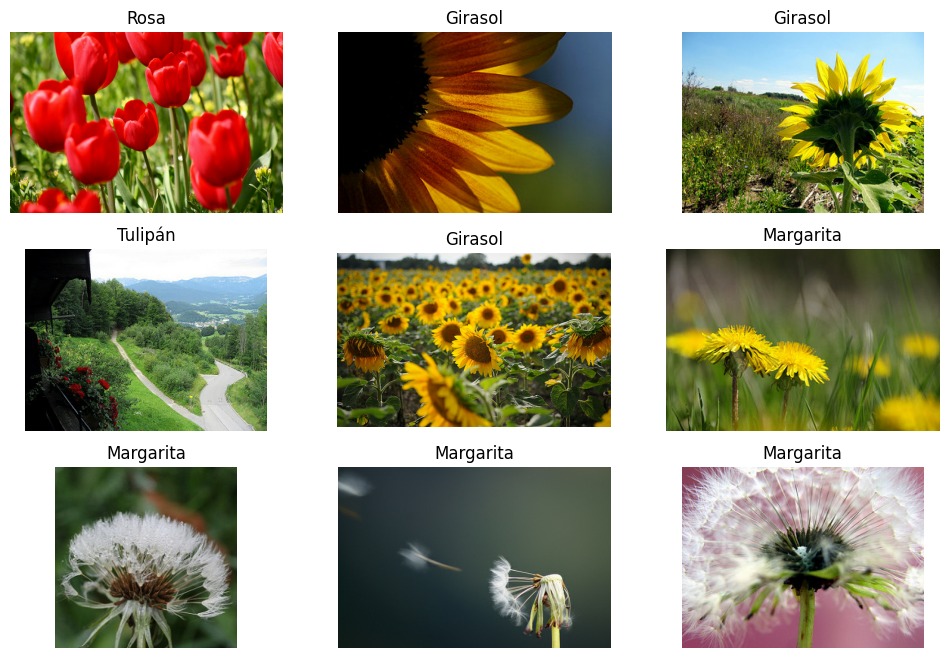

In [4]:
# Paso 1.1: Visualizar algunas imágenes del conjunto de entrenamiento

# Definimos una función para mostrar imágenes de muestra del dataset
def display_sample_images(dataset, class_names, num_images=9):
    # Configuramos el tamaño de la figura
    plt.figure(figsize=(12, 8))

    # Iteramos sobre el dataset, tomando la cantidad de imágenes que queramos mostrar
    for i, (image, label) in enumerate(dataset.take(num_images)):
        # Creamos un subplot de 3 filas x 3 columnas
        plt.subplot(3, 3, i + 1)

        # Mostramos la imagen (normalizándola al dividir entre 255.0 para que los valores estén entre 0 y 1)
        plt.imshow(image.numpy() / 255.0)

        # Colocamos el nombre de la clase como título (usando la etiqueta)
        plt.title(class_names[label.numpy()])

        # Quitamos los ejes para que se vea más limpio
        plt.axis('off')

    # Mostramos todas las imágenes juntas
    plt.show()

# Obtener los nombres de las clases manualmente (los tipos de flores en el dataset)
class_names = ['Margarita', 'Diente de león', 'Rosa', 'Girasol', 'Tulipán']

# Llamamos a la función para mostrar algunas imágenes del conjunto de entrenamiento
display_sample_images(ds_train, class_names)


In [5]:
# Paso 2: Preprocesar el conjunto de datos

# Definimos el tamaño al que queremos redimensionar todas las imágenes
IMG_SIZE = 128

# Función de preprocesamiento de imágenes
def preprocess(image, label):
    # Redimensionamos la imagen al tamaño deseado (IMG_SIZE x IMG_SIZE)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))

    # Normalizamos los valores de los píxeles dividiendo entre 255.0 para llevarlos al rango [0, 1]
    image = image / 255.0

    # Retornamos la imagen procesada y su etiqueta correspondiente
    return image, label

# Aplicar el preprocesamiento al conjunto de entrenamiento
ds_train = (
    ds_train
    .map(preprocess)                 # Aplicamos la función preprocess a cada imagen
    .batch(32)                        # Agrupamos las imágenes en lotes de 32
    .cache()                          # Guardamos en caché para que el dataset sea más rápido de cargar en cada época
    .prefetch(tf.data.AUTOTUNE)       # Preparamos datos mientras el modelo entrena para optimizar la velocidad
)

# Aplicar el mismo preprocesamiento al conjunto de validación
ds_val = (
    ds_val
    .map(preprocess)
    .batch(32)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)


In [6]:
# Paso 3: Construir el modelo
model = tf.keras.Sequential([  # Se crea un modelo secuencial, donde las capas se apilan de manera lineal

    # Capa Conv2D: Convolución con 48 filtros de tamaño (3x3), activación ReLU
    # Esta capa extrae características de las imágenes de entrada
    tf.keras.layers.Conv2D(48, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),

    # Capa MaxPooling2D: Realiza un muestreo en las dimensiones espaciales (reducción de tamaño)
    # Ayuda a reducir la dimensionalidad y el sobreajuste
    tf.keras.layers.MaxPooling2D(2, 2),

    # Segunda capa Conv2D: Convolución con 24 filtros, activación ReLU
    tf.keras.layers.Conv2D(24, (3, 3), activation='relu'),

    # Segunda capa MaxPooling2D: Nuevamente, realiza un muestreo para reducir el tamaño de la imagen
    tf.keras.layers.MaxPooling2D(2, 2),

    # Tercera capa Conv2D: Convolución con 12 filtros, activación ReLU
    tf.keras.layers.Conv2D(12, (3, 3), activation='relu'),

    # Tercera capa MaxPooling2D: Realiza el muestreo final antes de la capa densa
    tf.keras.layers.MaxPooling2D(2, 2),

    # Capa Flatten: Aplana la salida de las capas anteriores (de 2D a 1D)
    # Para que pueda ser pasada a las capas densas
    tf.keras.layers.Flatten(),

    # Capa Dense: Capa completamente conectada con 5 neuronas y activación ReLU
    # Esto sirve como una capa intermedia para aprender patrones más complejos
    tf.keras.layers.Dense(5, activation='relu'),

    # Capa de salida: Capa Dense con `num_classes` neuronas y activación softmax
    # La activación softmax se usa para clasificación múltiple (probabilidades)
    tf.keras.layers.Dense(num_classes, activation='softmax')  # Capa de salida para clasificación múltiple
])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
# Paso 4: Compilar el modelo
model.compile(optimizer='adam',  # Utiliza el optimizador Adam, que es popular por su eficiencia en la mayoría de los casos
              loss='sparse_categorical_crossentropy',  # Función de pérdida para clasificación múltiple cuando las etiquetas son enteros (no codificadas en one-hot)
              metrics=['accuracy'])  # La métrica de evaluación será la precisión (accuracy), que indica el porcentaje de predicciones correctas


In [8]:
# Paso 5: Entrenar el modelo
history = model.fit(ds_train,  # ds_train es el conjunto de datos de entrenamiento
                    epochs=20,  # Entrenar el modelo durante 20 épocas (iteraciones sobre todo el conjunto de datos)
                    validation_data=ds_val)  # ds_val es el conjunto de datos de validación, utilizado para evaluar el modelo después de cada época


Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 0.2047 - loss: 1.5591 - val_accuracy: 0.2466 - val_loss: 1.4782
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.2979 - loss: 1.4616 - val_accuracy: 0.2866 - val_loss: 1.4188
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3421 - loss: 1.4251 - val_accuracy: 0.3124 - val_loss: 1.3737
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3982 - loss: 1.3798 - val_accuracy: 0.3706 - val_loss: 1.3384
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4476 - loss: 1.3380 - val_accuracy: 0.4432 - val_loss: 1.3037
Epoch 6/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4783 - loss: 1.3064 - val_accuracy: 0.4723 - val_loss: 1.2984
Epoch 7/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4876 - loss: 1.2840 - val_accuracy: 0.4782 - val_loss: 1.2777
Epoch 8/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4962 - loss: 1.2620 - val_accuracy: 0.4741 -

In [9]:
# Paso 6: Evaluar el modelo
loss, accuracy = model.evaluate(ds_val)  # Evaluamos el modelo en el conjunto de validación (ds_val)
print(f'Precisión en el conjunto de validación: {accuracy:.2f}')  # Imprimimos la precisión obtenida en el conjunto de validación


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6564 - loss: 0.9077
Precisión en el conjunto de validación: 0.60


In [10]:
# Paso 7: Visualizar la precisión y la pérdida
plt.figure(figsize=(12, 4))  # Se crea una nueva figura para graficar la precisión y la pérdida, con un tamaño de 12x4 pulgadas


<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

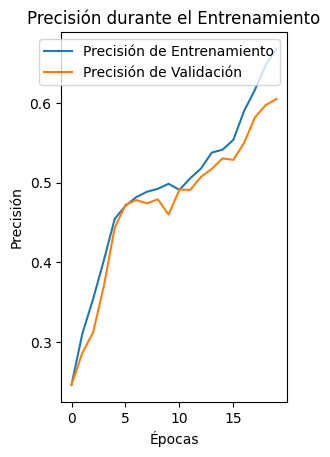

In [11]:
# Gráfico de precisión
plt.subplot(1, 2, 1)  # Crear el primer gráfico en una cuadrícula de 1 fila y 2 columnas
plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')  # Graficar la precisión del entrenamiento
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')  # Graficar la precisión de la validación
plt.title('Precisión durante el Entrenamiento')  # Título del gráfico
plt.xlabel('Épocas')  # Etiqueta del eje X (número de épocas)
plt.ylabel('Precisión')  # Etiqueta del eje Y (precisión)
plt.legend()  # Mostrar la leyenda que identifica las líneas del gráfico (entrenamiento vs validación)


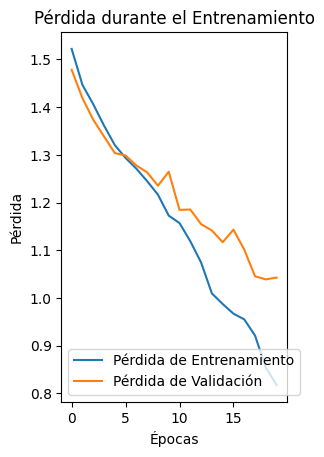

In [12]:
# Gráfico de pérdida
plt.subplot(1, 2, 2)  # Crear el segundo gráfico en una cuadrícula de 1 fila y 2 columnas, en la segunda posición
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')  # Graficar la pérdida del entrenamiento
plt.plot(history.history['val_loss'], label='Pérdida de Validación')  # Graficar la pérdida de la validación
plt.title('Pérdida durante el Entrenamiento')  # Título del gráfico
plt.xlabel('Épocas')  # Etiqueta del eje X (número de épocas)
plt.ylabel('Pérdida')  # Etiqueta del eje Y (pérdida)
plt.legend()  # Mostrar la leyenda para identificar las líneas de entrenamiento y validación

plt.show()  # Mostrar los gráficos en pantalla


In [13]:
# Paso 8: Inferencia en nuevas imágenes
# Función para preprocesar la imagen
def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))  # Cargar la imagen y redimensionarla al tamaño especificado (IMG_SIZE, IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)  # Convertir la imagen cargada a un array de numpy
    img_array = img_array / 255.0  # Normalizar la imagen para que los valores de los píxeles estén en el rango [0, 1]
    return np.expand_dims(img_array, axis=0)  # Añadir una dimensión extra para representar el batch (necesario para hacer predicciones)


In [14]:
# Función para hacer la predicción
def predict_flower(image_path):
    preprocessed_image = preprocess_image(image_path)  # Preprocesar la imagen antes de pasarla al modelo

    # Realizar la predicción
    prediction = model.predict(preprocessed_image)  # Hacer la predicción con el modelo (devuelve un array de probabilidades para cada clase)

    # Obtener la clase con la mayor probabilidad
    class_idx = np.argmax(prediction[0])  # Obtener el índice de la clase con la mayor probabilidad
    return class_idx, prediction[0][class_idx]  # Devolver el índice de la clase y la probabilidad correspondiente


In [16]:
# Ruta de la imagen a predecir
image_path = '/content/descargar.jpeg'  # Cambia esto a la ruta de tu imagen

# Realizar la predicción
predicted_class_idx, confidence = predict_flower(image_path)  # Llamar a la función de predicción


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step


In [17]:
# Mostrar los resultados
print(f'Predicción: {class_names[predicted_class_idx]} (Confianza: {confidence:.2f})')

Predicción: Girasol (Confianza: 0.28)


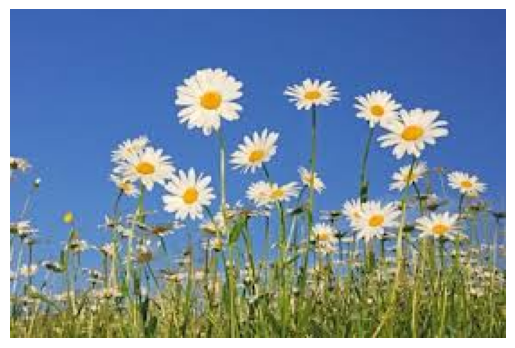

In [18]:
# Visualizar la imagen
img = tf.keras.preprocessing.image.load_img(image_path)  # Cargar la imagen original desde la ruta especificada

plt.imshow(img)  # Mostrar la imagen usando matplotlib
plt.axis('off')  # Ocultar los ejes (no mostrar líneas ni valores alrededor de la imagen)
plt.show()  # Mostrar la ventana con la imagen


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
La imagen no corresponde a ninguna categoría conocida (Confianza máxima: 0.28)


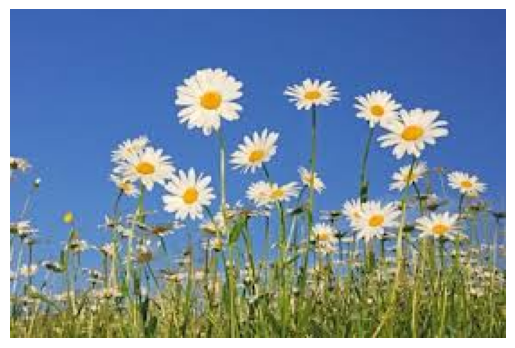

In [19]:
# Definir un umbral para determinar si la imagen no pertenece a las categorías conocidas
CONFIDENCE_THRESHOLD = 0.5  # Umbral de confianza (50%); si el modelo predice con menos certeza, se considerará "desconocido"

# Función para hacer la predicción con detección de imágenes fuera de categoría
def predict_flower_or_unknown(image_path):
    # Realizar la predicción
    prediction = model.predict(preprocess_image(image_path))

    # Obtener la clase con la mayor probabilidad
    class_idx = np.argmax(prediction[0])  # Índice de la clase con mayor probabilidad
    confidence = prediction[0][class_idx]  # Valor de confianza (probabilidad)

    # Comparar con el umbral
    if confidence < CONFIDENCE_THRESHOLD:
        return "Imagen desconocida", confidence  # Si la confianza es baja, se devuelve "Imagen desconocida"
    else:
        return class_names[class_idx], confidence  # Si es alta, se devuelve el nombre de la clase predicha

# Ruta de la imagen a predecir
image_path = '/content/descargar.jpeg'  # Cambiar si se prueba con otra imagen

# Realizar la predicción
predicted_label, confidence = predict_flower_or_unknown(image_path)

# Mostrar los resultados
if predicted_label == "Imagen desconocida":
    print(f"La imagen no corresponde a ninguna categoría conocida (Confianza máxima: {confidence:.2f})")
else:
    print(f'Predicción: {predicted_label} (Confianza: {confidence:.2f})')

# Visualizar la imagen
img = tf.keras.preprocessing.image.load_img(image_path)  # Cargar la imagen
plt.imshow(img)  # Mostrar la imagen
plt.axis('off')  # Quitar ejes
plt.show()  # Mostrar ventana de imagen
